 # Symulator Tomografu Jakub Gardecki 141218 Mateusz Kempa 139952 

# Biblioteki

In [1]:
from __future__ import print_function
import os
import shutil
import sys
from matplotlib import pyplot
import numpy as np
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from ipywidgets import Layout, VBox
from IPython.display import Markdown, Image
import datetime
import math
import matplotlib
import matplotlib.pyplot as plt
import skimage
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
from skimage.draw import circle
from bresenham import bresenham
import pydicom
from pydicom import dcmread
from pydicom.dataset import Dataset, FileDataset
import tempfile
import warnings
import imageio
from natsort import natsorted

#wielkość
plt.rcParams['figure.figsize'] = [7, 7]

#Globalne zmienne 
OdtZdj = []

# Tworzenie maski

In [2]:
def tworzenie_maski(liczba_detektorow):
    rozmiar_maski = liczba_detektorow //2
    if(rozmiar_maski % 2 == 0):
        rozmiar_maski += 1
    maska = np.zeros((rozmiar_maski))
    top = -4/(np.pi**2)
    srodek = rozmiar_maski // 2
    for i in range(0, rozmiar_maski):
        maska[i] = (0 if (i-srodek)%2==0 else (top/((i-srodek)**2)) )
    maska[srodek]=1
    return maska

# Splot

In [3]:
def splot(tab,maska,liczbaSkanow):
    wyj_sinogram = np.zeros_like(tab)
    for i in range(liczbaSkanow):
                wyj_sinogram[i] = np.convolve(tab[i], maska, mode = 'same')
    return wyj_sinogram

# Normalizacja

In [4]:
def normalizacja(zdj):
    min_value = np.min(zdj)
    max_value = np.max(zdj)

    for i in range(len(zdj)):
        for j in range(len(zdj[i])):
            zdj[i, j] = (zdj[i, j] - min_value) / (max_value - min_value) 

    return zdj

 # Pierwiastek błędu średniokwadratowego

In [5]:
def RMSE(tabA, tabB):
    return np.sqrt(np.mean((tabA-tabB)**2))

# Utworzenie pliku gif do odtworzenia kroków pośrednich

In [6]:
def gif_create():
    folder = 'ZdjWynikowe' 
    files = [f"{folder}\\{file}" for file in os.listdir(folder)]
    files = natsorted(files)
    images = [imageio.imread(file) for file in files]
    imageio.mimwrite('kroki.gif', images, fps=4)


# Odczyt / zapisc plików DICOM

In [12]:
def save_dicom_file(pic, patient_data, filename="dicom/test.dcm"):
    filename_little_endian = tempfile.NamedTemporaryFile(suffix=".dcm").name
    file_meta = Dataset()
    file_meta.MediaStorageSOPClassUID = '1.2.840.10008.5.1.4.1.1.2'
    file_meta.MediaStorageSOPInstanceUID = "1.2.3"
    file_meta.ImplementationClassUID = "1.2.3.4"

    ds = FileDataset(filename_little_endian, {},
                     file_meta=file_meta, preamble=b"\0" * 128)
    ds.PatientName = patient_data["PatientName"]
    ds.PatientWeight = patient_data["PatientWeight"]
    ds.ImageComments = patient_data["ImageComments"]
    ds.StudyDate = patient_data["StudyDate"]
    ds.PatientBirthDate = patient_data["BirthDate"]


    if pic.dtype != np.uint8:
        img_max = np.max(pic)
        img_min = np.min(pic)
        pic = ((pic - img_min) / (img_max - img_min) * 255)
        pic = pic.astype(np.uint8)

    ds.SpecificCharacterSet = 'utf-8'
    ds.PixelData = pic.tobytes()
    ds.Rows, ds.Columns = pic.shape[0:2]
    ds.BitsStored = 8
    ds.BitsAllocated = 8
    ds.HighBit = 7
    ds.SamplesPerPixel = 1
    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.PixelRepresentation = 0

    ds.save_as(filename, write_like_original=False)
    print("Plik pomyślnie zapisany.")
        
def on_create_dicom_clicked(x):
    global OdtworzoneZdj
    patient_data = {}
    patient_data["PatientName"] = imie_pacjenta_input.value
    patient_data["PatientWeight"] = waga_pacjenta_input.value
    patient_data["ImageComments"] = zdj_komentarz.value
    patient_data["StudyDate"] = data_badania_pacjenta.value
    patient_data["BirthDate"] = data_urodzenia_input.value
    print("Dane Pacjenta: ")
    print(patient_data)
    
    matplotlib.image.imsave("zdj/pom.jpg", OdtZdj)
    dicom_pic = imread("zdj/pom.jpg") 
    dicom_pic = rgb2gray(dicom_pic)
    save_dicom_file(dicom_pic,patient_data)
        

    
def load_dicom_file(filename="dicom/test.dcm"):
    ds = pydicom.dcmread(filename)
    image = ds.pixel_array
    # Convert the image data type to uint8
    if image.dtype != np.uint8:
        img_max = np.max(image)
        img_min = np.min(image)
        image = 255 * (image - img_min) / (img_max - img_min)

    patient_data = {}

    if "PatientName" in ds:
        patient_data["PatientName"]=ds.PatientName
    if "ImageComments" in ds:
        patient_data["ImageComments"]=ds.ImageComments
    if "StudyDate" in ds:
        patient_data["StudyDate"]=ds.StudyDate
    if "PatientBirthDate" in ds:
        patient_data["BirthDate"]=ds.PatientBirthDate
    if "PatientWeight" in ds:
        patient_data["PatientWeight"]=ds.PatientWeight

    plt.imshow(image.astype(np.uint8), cmap=plt.cm.bone)
    return   image.astype(np.uint8), patient_data
    

def on_load_dicom_clicked(x):
    image, data = load_dicom_file()
    print(data) 




# Funkcja main

In [8]:
def main(krok = 360, liczba_detektorow = 300, rozpietosc = 270, uzycie_Maski = True, nazwaPliku = "Kwadraty2.jpg"):
    
    global OdtZdj
    DICOM_moze = False
    zdj = "zdj/" + "nazwaPliku"
    NazwaFolderuWyj = "ZdjWynikowe"
    zdj = imread(nazwaPliku)
    zdj = rgb2gray(zdj)
    zdj = resize(zdj, (400, 400),anti_aliasing=True)
    wys, szer = zdj.shape # wysokosc, szerokosc
    promien = min(wys, szer) / 2 - 1 #należy odsunąć się od krawędzi
    srodek = wys / 2, szer / 2
    #krok = 360
    #liczba_detektorow = 300
    #rozpietosc = 270 # phi
    sinogram = np.zeros((krok, liczba_detektorow))
    OdtworzoneZdj = np.zeros((wys, szer))
    
    alfa = 360 / krok
    #Tworzenie sinogramu
    for i in range(0, krok):
        sys.stdout.write(str(i) + " / " + str(krok-1)+ '\r')
        sys.stdout.flush()
        xEmiter = int(round(promien * math.cos(math.radians(alfa * i)) + srodek[1], 1))
        yEmiter = int(round(promien * math.sin(math.radians(alfa * i)) + srodek[0], 1))
        for j in range(0, liczba_detektorow):
            xDetektor = int(round(promien * math.cos(math.radians(alfa * i + 180 - rozpietosc / 2 + j * rozpietosc / (liczba_detektorow - 1))), 1) + srodek[1])
            yDetektor = int(round(promien * math.sin(math.radians(alfa * i + 180 - rozpietosc / 2 + j * rozpietosc / (liczba_detektorow - 1))), 1) + srodek[0])
            Linia = bresenham(xEmiter, yEmiter, xDetektor, yDetektor)
            for x, y in Linia:
                sinogram[i,j] += zdj[x,y]
    
    if (uzycie_Maski): 
        #Stworzenie sinogramu po zastosowaniu maski
        maska = tworzenie_maski(liczba_detektorow)
        sinogram_splot = splot(sinogram, maska, krok)
    else:
        sinogram_splot = sinogram
    print("Sinogram:")
    plt.imshow(sinogram_splot, cmap='gray')
    plt.show()
    
    #Odzyskanie zdjęcia z sinogramu
    for i in range(0, krok):
        sys.stdout.write(str(i) + " / " + str(krok-1)+ '\r')
        sys.stdout.flush()
        xEmiter = int(round(promien * math.cos(math.radians(alfa * i)) + srodek[1], 1))
        yEmiter = int(round(promien * math.sin(math.radians(alfa * i)) + srodek[0], 1))
        for j in range(0, liczba_detektorow):
            xDetektor = int(round(promien * math.cos(math.radians(alfa * i + 180 - rozpietosc / 2 + j * rozpietosc / (liczba_detektorow - 1))), 1) + srodek[1])
            yDetektor = int(round(promien * math.sin(math.radians(alfa * i + 180 - rozpietosc / 2 + j * rozpietosc / (liczba_detektorow - 1))), 1) + srodek[0])
            Linia = bresenham(xEmiter, yEmiter, xDetektor, yDetektor)
            for y, x in Linia:
                OdtworzoneZdj[y][x] += sinogram_splot[i][j]
        #save image
        if (i % 10 == 0 or i == krok - 1):
            plt.imsave(NazwaFolderuWyj + "/zdj" + str(i) + ".png", OdtworzoneZdj, cmap='gray')
            
    OdtworzoneZdj = normalizacja(OdtworzoneZdj)
    OdtZdj = OdtworzoneZdj 
    print("Pierwiastek błędu średniokwadratowego (RMSE):  ", RMSE(zdj, OdtworzoneZdj))
    print("Odtworzony Obraz:")
    plt.imshow(OdtworzoneZdj, cmap='gray')
    plt.show()
    print("Odtworzony Obraz z krokiem co 10: ")
    gif_create()
    with open('kroki.gif','rb') as f:
        display(Image(data=f.read(), format='png'))

# Interfejs Użytkownika

Parametry: 


IntSlider(value=180, continuous_update=False, description='L skanów: ', max=720, min=30, step=10)

IntSlider(value=180, continuous_update=False, description='L detektorów: ', max=720, min=90, step=90)

IntSlider(value=180, continuous_update=False, description='Rozpietosc: ', max=315, min=45, step=45)

Checkbox(value=False, description='Zastosuj Filtr')

Button(description='Uruchom', style=ButtonStyle())



 Kreator DICOM: 




 Zdjęcie wejściowe:


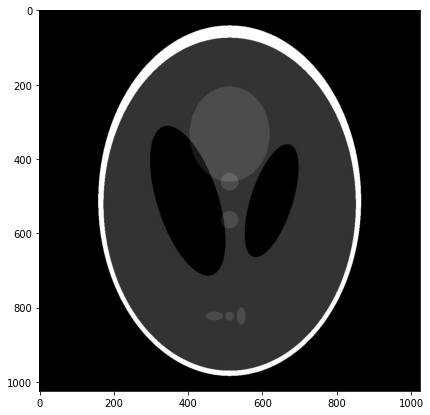

Sinogram:


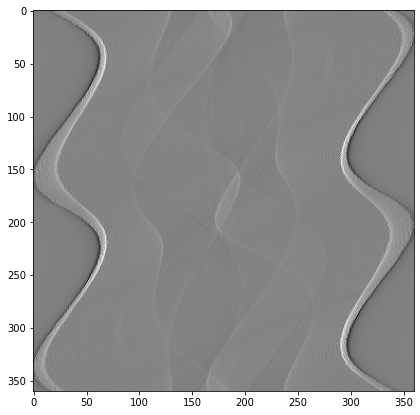

In [13]:


sliderKrok = widgets.IntSlider(
    value=180,
    min=30,
    max=720,
    step=10,
    description='L skanów: ',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

sliderNdetektorow = widgets.IntSlider(
    value=180,
    min=90,
    max=720,
    step=90,
    description='L detektorów: ',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)

sliderRozpietosc = widgets.IntSlider(
    value=180,
    min=45,
    max=315,
    step=45,
    description='Rozpietosc: ',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d'
)


checkFiltr = widgets.Checkbox(
    value=False,
    description='Zastosuj Filtr',
    disabled=False
)

executeButton = widgets.Button(description='Uruchom')

print("Parametry: ")
display(sliderKrok)
display(sliderNdetektorow)

display(sliderRozpietosc)
display(checkFiltr)
display(executeButton)

print("\n\n Kreator DICOM: ")
style = {'description_width': 'initial'}
imie_pacjenta_input = widgets.Text(description="Imie Pacjęta: ",value='Robert Maklowicz', style=style)
waga_pacjenta_input = widgets.FloatText(description="Waga Pacjenta: ",value=80, style=style)
data_urodzenia_input = widgets.Text(description="Data urodzenia (YYYYMMDD)", value="19650820", style=style)
current_date= datetime.datetime.now()
data_badania_pacjenta = widgets.Text(description="Data Badania (YYYYMMDD)", value=str(current_date.strftime('%Y%m%d')), style=style)
zdj_komentarz = widgets.Text(description="Komenatrz: ", style=style)

create_dicom_button = widgets.Button(description = "Utwórz plik dicom")
create_dicom_button.on_click(on_create_dicom_clicked)

load_dicom_button = widgets.Button(description = "Załaduj plik dicom")
load_dicom_button.on_click(on_load_dicom_clicked)
dicom_box = VBox([imie_pacjenta_input, waga_pacjenta_input, data_urodzenia_input, data_badania_pacjenta, zdj_komentarz, create_dicom_button, load_dicom_button])
display(dicom_box)

nazwaPliku = "zdj/" + "Shepp_logan.jpg"
print("\n\n Zdjęcie wejściowe:")
plt.imshow(imread(nazwaPliku))
plt.show()

def onClick(b):
    main(sliderKrok.value, sliderNdetektorow.value, sliderRozpietosc.value, checkFiltr.value, nazwaPliku)

executeButton.on_click(onClick)



